# Training PGGANs on the LiTS datasets: preprocessing

- [LiTS - Liver Tumor Segmentation Challenge](https://competitions.codalab.org/competitions/17094)

![](https://newcodalab.lri.fr/prod-public/logos/logo_807.jpg)

# 1. 데이터 정리

In [ ]:
import boto3
s3 = boto3.resource('s3')
bucket = "sagemaker-jhgan-workspace"
my_bucket = s3.Bucket(bucket)

In [ ]:
for obj in my_bucket.objects.filter(Prefix="train/img"):
    print(obj.key)
    fname = obj.key.split("/")[1]
    copy_source = {
        "Bucket":bucket,
        "Key":obj.key
    }
    s3.meta.client.copy(copy_source, bucket, f"NII/{fname}")

In [ ]:
for obj in my_bucket.objects.filter(Prefix="test_noGT"):
    print(obj.key)
    fname = obj.key.split("/")[1]
    copy_source = {
        "Bucket":bucket,
        "Key":obj.key
    }
    s3.meta.client.copy(copy_source, bucket, f"NII/test_{fname}")

# 2. 전처리

## 2.1 Windowing

When presented with a WW and WL one can calculate the upper and lower grey levels i.e. values over x will be white and values below y will be black. 

- the upper grey level (x) is calculated via WL + (WW ÷ 2)
- the lower grey level (y) is calculated via WL - (WW ÷ 2)

```python
def create_from_nii(tfrecord_dir, nii_dir, shuffle):
    import SimpleITK as sitk
    import pandas as pd
    def window(img, WL=30, WW=150):
        w = WW * 0.5
        lower, upper = WL - w, WL + w
        return img.clip(lower, upper) - lower

    def getArrayFromNii(nii):
        return sitk.GetArrayFromImage(sitk.ReadImage(nii))
    
    print('Loading images from "%s"' % nii_dir)
    image_filenames = sorted(glob.glob(os.path.join(nii_dir, '*')))
    levels = pd.read_csv("/opt/ml/processing/code/LiTS-Liver.csv").set_index("case")
    
    if len(image_filenames) == 0:
        error('No input images found')

    img = np.expand_dims(getArrayFromNii(image_filenames[0]), axis=-1)
    resolution = img.shape[1]
    
    if img.shape[2] != resolution:
        error('Input images must have the same width and height')
    
    if resolution != 2 ** int(np.floor(np.log2(resolution))):
        error('Input image resolution must be a power-of-two')

    with TFRecordExporter(tfrecord_dir, len(image_filenames), False) as tfr:
        order = tfr.choose_shuffled_order() if shuffle else np.arange(len(image_filenames))
        for idx in range(order.size):
            fpath = image_filenames[order[idx]]
            print(fpath)
            
            fname = fpath.split("/")[-1]
            level = levels.loc[fname].values.astype(int)
            
            if (level==0).all():
                continue
            imgs = getArrayFromNii(fpath)[level[0]:level[1]]
            windowed_imgs = window(imgs)
            for img in windowed_imgs:
                img = img[np.newaxis, :, :]
                tfr.add_image(img)
```

## 2.2. 도커 이미지 푸시

```bash
aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 349048005035.dkr.ecr.us-east-2.amazonaws.com
docker tag <image name> <repository name>
docker push <repository name>
```


## 2.3. `ScriptProcessor` 실행

- [`Processor` 클래스 Readthedocs](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ScriptProcessor)
- [Run Scripts with Your Own Processing Container](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-container-run-scripts.html)

In [85]:
import boto3
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput, ScriptProcessor
from sagemaker import get_execution_role
from sagemaker.session import Session
s3 = boto3.resource('s3')
BUCKET_NAME = "sagemaker-jhgan-workspace"
DOCKER_IMAGE_URI = "349048005035.dkr.ecr.us-east-2.amazonaws.com/pggan:1.15.3-gpu-py3"
VOLUME_SIZE = 200
JOB_NAME="LiTS-window-liver-08"

In [86]:
inputObject = ProcessingInput(
    source=f's3://sagemaker-jhgan-workspace/NII',
    destination=f'/opt/ml/processing/input_data'
)

inputSource = ProcessingInput(
    source = "./",
    destination = "/opt/ml/processing/code"
)

In [87]:
script_processor = ScriptProcessor(
    image_uri = DOCKER_IMAGE_URI,
    volume_size_in_gb = VOLUME_SIZE,
    role = get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.4xlarge',
    command = ["python"],
    sagemaker_session=Session(default_bucket = BUCKET_NAME)
)

In [ ]:
script_processor.run(
    code = "dataset_tool.py",
    inputs=[inputObject, inputSource],
    outputs=[ProcessingOutput(source='/opt/ml/processing/processed_data')],
    job_name= JOB_NAME
)

# 3. 데이터셋 점검

`tfrecords` 파일들은 각각 $2^2 \times 2^2$부터 $2^9 \times 2^9$ 해상도를 가져야 한다.

> The datasets are represented by directories containing the same image data in several resolutions to enable efficient streaming. There is a separate *.tfrecords file for each resolution, and if the dataset contains labels, they are stored in a separate file as well:

In [89]:
import tensorflow as tf
import numpy as np

In [90]:
# Parse individual image from a tfrecords file.
def parse_tfrecord_tf(record):
    features = tf.parse_single_example(record, features={
        'shape': tf.FixedLenFeature([3], tf.int64),
        'data': tf.FixedLenFeature([], tf.string)})
    data = tf.decode_raw(features['data'], tf.uint8) # uint8 > int16
    return tf.reshape(data, features['shape'])

def parse_tfrecord_np(record):
    ex = tf.train.Example()
    ex.ParseFromString(record)
    shape = ex.features.feature['shape'].int64_list.value
    data = ex.features.feature['data'].bytes_list.value[0]
    return np.frombuffer(data, np.uint8).reshape(shape) # uint8 > int16

In [91]:
prefix = f"s3://sagemaker-jhgan-workspace/{JOB_NAME}/output/output-1/"
tfr_files = [prefix + f"processed_data-r0{i}.tfrecords" for i in range(2, 10)]

In [92]:
tfr_shapes = []
print("{:<10} | {:<10} | {:<15}".format("Min", "Max", "Shape"))
print("-"*40)
tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
for tfr_file in tfr_files:
    for record in tf.python_io.tf_record_iterator(tfr_file, tfr_opt):
        arr =  parse_tfrecord_np(record)
        Min, Max, Shape = arr.min(), arr.max(), arr.shape
        print ("{:<10} | {:<10} | {:<15}".format(str(Min),str(Max),f"{Shape}"))
        break

Min        | Max        | Shape          
----------------------------------------
0          | 107        | (1, 4, 4)      
0          | 127        | (1, 8, 8)      
0          | 150        | (1, 16, 16)    
0          | 150        | (1, 32, 32)    
0          | 150        | (1, 64, 64)    
0          | 150        | (1, 128, 128)  
0          | 150        | (1, 256, 256)  
0          | 150        | (1, 512, 512)  


(-0.5, 511.5, 511.5, -0.5)

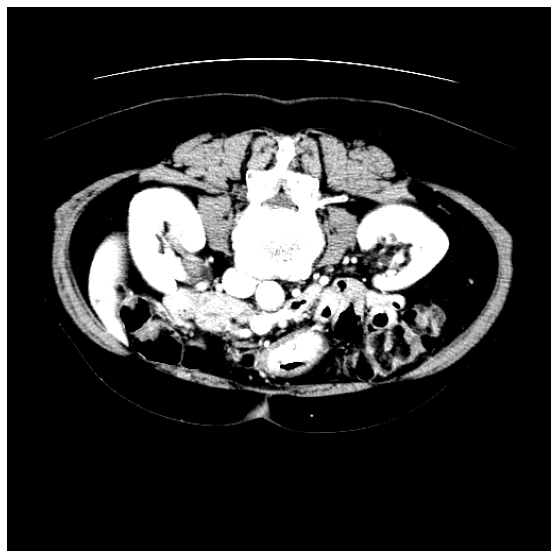

In [93]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(arr[0].astype(np.float32), cmap="gray")
plt.axis("off")